# 1) Import libraries

In [113]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import transformers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pickle
from nltk.stem import PorterStemmer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, concatenate

# 2) Load and Analyze the Data

In [3]:
df = pd.read_csv('data/train-balanced-sarcasm.csv')

In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df.shape

(1010826, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
# Identify the columns that have null values
null_mask = df.isnull()
null_counts = null_mask.sum()

cols_with_nulls = null_counts[null_counts > 0].index.tolist()
# Columns and number of nulls in them
null_counts

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [8]:
# replace NA comments with empty strings
df[cols_with_nulls] = df[cols_with_nulls].fillna('')

In [9]:
# check data is balanced or not
df['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

# 3) Data Pre-Processing

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [54]:
def preprocess_text(text, stemming=False):
    
    # Convert text to lowercase
    text = text.lower()
    
    # Decontraction
    words = text.split()
    decontracted_words = [contraction_mapping[word] if word in contraction_mapping else word for word in words]
    text = ' '.join(decontracted_words)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    if stemming==True:
        porter = PorterStemmer()
        # Apply stemming to each word in the list
        filtered_words = [porter.stem(word) for word in filtered_words]
    
    text = ' '.join(filtered_words)

    return str(text)

In [12]:
df['comment'] = df['comment'].apply(preprocess_text)

In [13]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west teams play west teams east teams right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdogs earlier today since gronks announcem...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme funny none new york nigga ones,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# 4) Data Visualization

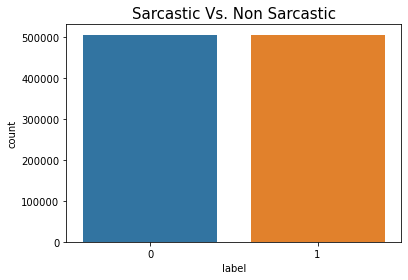

In [14]:
# Visualizing the number of sarcastic and non sarcastic comments
plt.figure(figsize = None)
sns.countplot(x=df["label"])
plt.title("Sarcastic Vs. Non Sarcastic", fontsize = 15)
plt.show()

In [15]:
sarcastic_df = df[df['label'] == 1][['comment']]
non_sarcastic_df = df[df['label'] == 0][['comment']]

In [16]:
sarcastic_comments = " ".join(str(comment) for comment in sarcastic_df['comment'])
non_sarcastic_comments = " ".join(comment for comment in non_sarcastic_df['comment'])

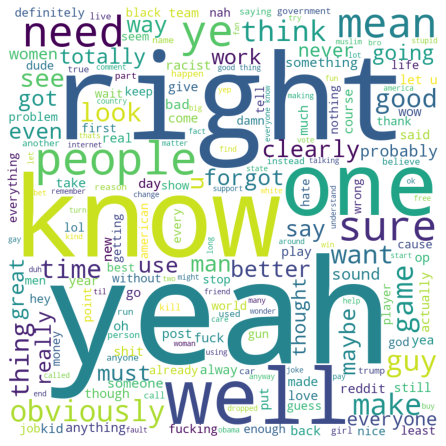

In [17]:
# Plotting word cloud for sarcastic comments

sarcastic_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', max_words=200, 
                      colormap='viridis', contour_width=1, contour_color='black').generate(sarcastic_comments)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(sarcastic_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

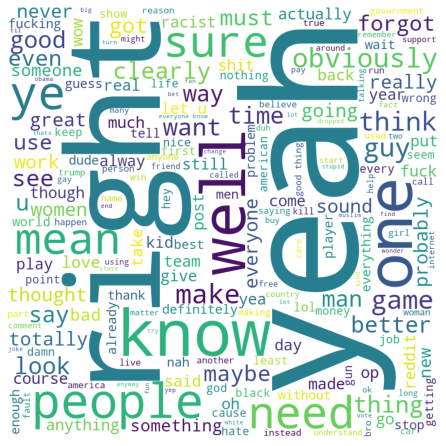

In [18]:
# Plotting word cloud for non sarcastic comments

non_sarcastic_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', max_words=200, 
                      colormap='viridis', contour_width=1, contour_color='black').generate(sarcastic_comments)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(non_sarcastic_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [19]:
# Finding Most Common words in Sarcastic and Non-Sarcastic Comments

sarcastic_words = [word for comment in sarcastic_df['comment'] for word in word_tokenize(comment)]

# Tokenize non-sarcastic comments
non_sarcastic_words = [word for comment in non_sarcastic_df['comment'] for word in word_tokenize(comment)]

In [20]:
# Count the words in sarcastic comments
sarcastic_word_counts = Counter(sarcastic_words)

# Count the words in non-sarcastic comments
non_sarcastic_word_counts = Counter(non_sarcastic_words)

In [21]:
# Get top 20 words in sarcastic comments
frequent_sarcastic_words = sarcastic_word_counts.most_common(20)

# Get top 20 words in non-sarcastic comments
frequent_non_sarcastic_words = non_sarcastic_word_counts.most_common(20)

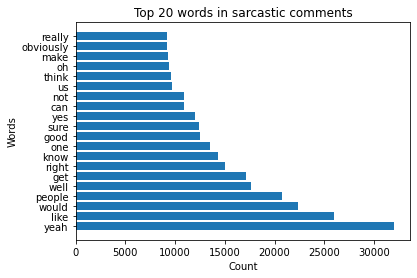

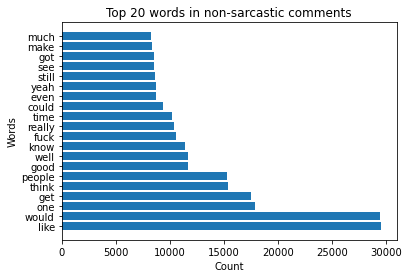

In [22]:
# Plot the top 20 words in sarcastic comments
plt.barh(range(len(frequent_sarcastic_words)), [val[1] for val in frequent_sarcastic_words], align='center')
plt.yticks(range(len(frequent_sarcastic_words)), [val[0] for val in frequent_sarcastic_words])
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 words in sarcastic comments')
plt.show()

# Plot the top 20 words in non-sarcastic comments
plt.barh(range(len(frequent_non_sarcastic_words)), [val[1] for val in frequent_non_sarcastic_words], align='center')
plt.yticks(range(len(frequent_non_sarcastic_words)), [val[0] for val in frequent_non_sarcastic_words])
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Top 20 words in non-sarcastic comments')
plt.show()


In [23]:
def calculate_metrics(test_labels, test_predictions):
    # Generate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print('Accuracy:')
    print(accuracy)
    print("-------------------------------------------------")
    
    # Generate confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    print('Confusion matrix:')
    print(cm)
    print("-------------------------------------------------")

    # Generate classification report
    cr = classification_report(test_labels, test_predictions)
    print('Classification report:')
    print(cr)
    print("-------------------------------------------------")

# 5) Model Building

## Naive Bayes(Bag of Words)

In [24]:
# Train Test Split
X = df['comment']  # Features
y = df['label']    # Target variable
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Vectorize input data using CountVector
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

In [26]:
# Initialize MultiNomialNaiveBayes
nb_bag_of_words = MultinomialNB()
nb_bag_of_words.fit(train_features, train_labels)

MultinomialNB()

In [27]:
test_predictions = nb_bag_of_words.predict(test_features)
calculate_metrics(test_labels, test_predictions)

Accuracy:
0.6595223727036198
-------------------------------------------------
Confusion matrix:
[[65026 36074]
 [32759 68307]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    101100
           1       0.65      0.68      0.66    101066

    accuracy                           0.66    202166
   macro avg       0.66      0.66      0.66    202166
weighted avg       0.66      0.66      0.66    202166

-------------------------------------------------


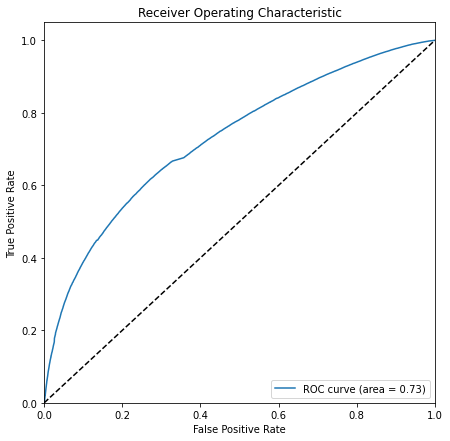

In [28]:
# Generate ROC curve and calculate AUC
probs = nb_bag_of_words.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Testing model on a sample example sentence
example_sentence = ["because giving you a sarcastic sentence is the most important thing in the world right now"]
example_features = vectorizer.transform(example_sentence)
prediction = nb_bag_of_words.predict(example_features)
if prediction[0] == 0:
    print("Example sentence is not sarcastic")
elif prediction[0] == 1:
    print("Example sentence is sarcastic")

Example sentence is sarcastic


In [30]:
# Save model to a file
file_path = 'model_files/nb_bag_of_words.pkl'

# Open the file for writing
with open(file_path, 'wb') as f:
    # Serialize and write the model to the file
    pickle.dump(nb_bag_of_words, f)

## Naive Bayes (TFIDF)

In [31]:
# Vectorize input data using TFIDFVectorizer
tfidf_vectorizer = TfidfVectorizer()
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features = tfidf_vectorizer.transform(test_data)

In [32]:
# Initialize MultiNomialNaiveBayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_features, train_labels)

MultinomialNB()

In [33]:
test_predictions = nb_tfidf.predict(test_features)
calculate_metrics(test_labels, test_predictions)

Accuracy:
0.656228050216159
-------------------------------------------------
Confusion matrix:
[[64637 36463]
 [33036 68030]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    101100
           1       0.65      0.67      0.66    101066

    accuracy                           0.66    202166
   macro avg       0.66      0.66      0.66    202166
weighted avg       0.66      0.66      0.66    202166

-------------------------------------------------


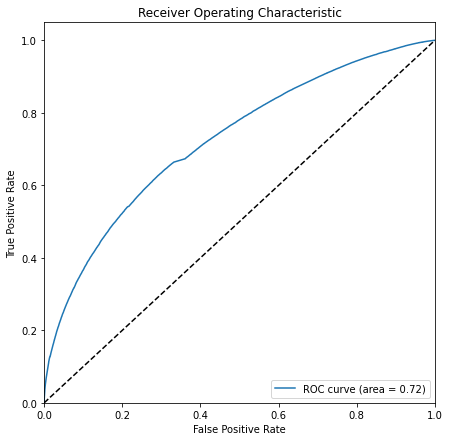

In [34]:
# Generate ROC curve and calculate AUC
probs = nb_tfidf.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Testing model on a sample example sentence
example_sentence = ["ChatGPT is a recent revolution"]
example_features = vectorizer.transform(example_sentence)
prediction = nb_tfidf.predict(example_features)
if prediction[0] == 0:
    print("Example sentence is not sarcastic")
elif prediction[0] == 1:
    print("Example sentence is sarcastic")

Example sentence is not sarcastic


In [36]:
# Save model to a file
file_path = 'model_files/nb_tfidf.pkl'

# Open the file for writing
with open(file_path, 'wb') as f:
    # Serialize and write the model to the file
    pickle.dump(nb_tfidf, f)

## Logistic Regression

In [37]:
# # Initialize LogisticRegression Classifier
logistic_classifier = LogisticRegression()
logistic_classifier.fit(train_features, train_labels)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
# Evaluate performance on test set
test_predictions = logistic_classifier.predict(test_features)
calculate_metrics(test_labels, test_predictions)

Accuracy:
0.6778340571609469
-------------------------------------------------
Confusion matrix:
[[72381 28719]
 [36412 64654]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69    101100
           1       0.69      0.64      0.67    101066

    accuracy                           0.68    202166
   macro avg       0.68      0.68      0.68    202166
weighted avg       0.68      0.68      0.68    202166

-------------------------------------------------


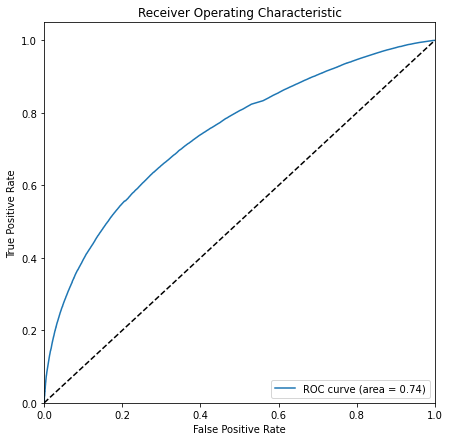

In [39]:
# Generate ROC curve and calculate AUC
probs = logistic_classifier.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Testing model on a sample example sentence
example_sentence = ["I'm always here to assist you with any questions or tasks you may have."]
example_features = vectorizer.transform(example_sentence)
prediction = logistic_classifier.predict(example_features)
if prediction[0] == 0:
    print("Example sentence is not sarcastic")
elif prediction[0] == 1:
    print("Example sentence is sarcastic")

Example sentence is not sarcastic


In [41]:
# Save model to a file
file_path = 'model_files/logistic_classifier.pkl'

# Open the file for writing
with open(file_path, 'wb') as f:
    # Serialize and write the model to the file
    pickle.dump(logistic_classifier, f)

## CNN

In [42]:
# Extracting comment and label columns as numpy arrays
X = df['comment'].values
y = df['label'].values
# Creating a tokenizer object and fitting it on the comment text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [43]:
# Converting the comment text data to sequences of integer values 
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to a fixed length of 100
X = pad_sequences(X, maxlen=100)

In [44]:
# Do a test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Creating a Sequential model
cnn_model = Sequential()
# Adding an embedding layer with input dimensions 10,000, output dimensions 100, and an input length of 100
cnn_model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
# Adding a 1D convolution layer with 64 filters, kernel size of 3, and relu activation function
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# Adding a 1D max pooling layer with a pool size of 2
cnn_model.add(MaxPooling1D(pool_size=2))
# Adding another 1D convolution layer with 32 filters, kernel size of 3, and relu activation function
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# Adding a global max pooling layer to extract the most important features
cnn_model.add(GlobalMaxPooling1D())
# Adding a dense layer with 64 units and relu activation function
cnn_model.add(Dense(units=64, activation='relu'))
# Adding a dropout layer to reduce overfitting with a dropout rate of 0.2
cnn_model.add(Dropout(rate=0.2))
# Adding a dense layer with 1 unit and sigmoid activation function to output binary classification results
cnn_model.add(Dense(units=1, activation='sigmoid'))
# Compiling the model with binary crossentropy loss, adam optimizer, and accuracy metric
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/10
25271/25271 [==============================] - 216s 9ms/step - loss: 0.6057 - accuracy: 0.6651 - val_loss: 0.5808 - val_accuracy: 0.6903
Epoch 2/10
25271/25271 [==============================] - 213s 8ms/step - loss: 0.5627 - accuracy: 0.7065 - val_loss: 0.5785 - val_accuracy: 0.6922
Epoch 3/10
25271/25271 [==============================] - 212s 8ms/step - loss: 0.5384 - accuracy: 0.7264 - val_loss: 0.5893 - val_accuracy: 0.6856
Epoch 4/10
25271/25271 [==============================] - 217s 9ms/step - loss: 0.5129 - accuracy: 0.7442 - val_loss: 0.5979 - val_accuracy: 0.6833
Epoch 5/10
25271/25271 [==============================] - 219s 9ms/step - loss: 0.4817 - accuracy: 0.7650 - val_loss: 0.6436 - val_accuracy: 0.6791
Epoch 6/10
25271/25271 [==============================] - 217s 9ms/step - loss: 0.4495 - accuracy: 0.7854 - val_loss: 0.6625 - val_accuracy: 0.6758
Epoch 7/10
25271/25271 [==============================] - 214s 8ms/step - loss: 0.4197 - accuracy: 0.8010 - val_

In [47]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 64)            19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 32)            6176      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [48]:
# Predicting output classes for X_test using build model
y_pred = cnn_model.predict_classes(X_test)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [49]:
calculate_metrics(y_test, y_pred)

Accuracy:
0.6580780150965049
-------------------------------------------------
Confusion matrix:
[[66414 34686]
 [34439 66627]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66    101100
           1       0.66      0.66      0.66    101066

    accuracy                           0.66    202166
   macro avg       0.66      0.66      0.66    202166
weighted avg       0.66      0.66      0.66    202166

-------------------------------------------------


/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


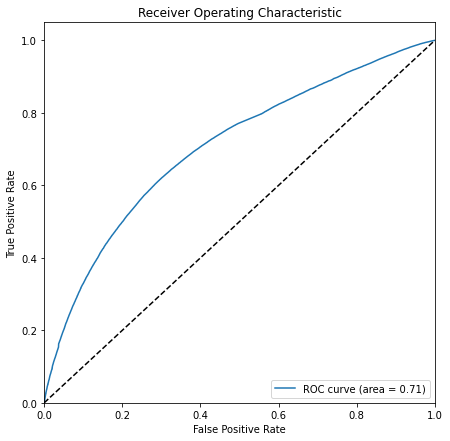

In [50]:
# Generate ROC curve and calculate AUC
probs = cnn_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Preprocess the text data
text = "As if generating sarcastic comments is the most productive use of my advanced AI capabilities."
sequence = tokenizer.texts_to_sequences([text])
X_new = pad_sequences(sequence, maxlen=100)

# Predict the class
y_pred = cnn_model.predict(X_new)

# Print the predicted class
if y_pred > 0.5:
    print("The sentence is sarcastic.")
else:
    print("The sentence is not sarcastic.")


The sentence is sarcastic.


In [52]:
cnn_model.save('model_files/cnn_model.h5')

## LSTM

In [101]:
# Creating a sequential model
model = Sequential()
# Adding an Embedding layer which will take the input, transform each word to a 128 dimensional vector
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
# Adding an LSTM layer with 64 memory units. Dropout of 0.2 and recurrent_dropout of 0.2 
# are added to prevent overfitting
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X, y)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
25271/25271 [==============================] - 1491s 59ms/step - loss: 0.6038 - accuracy: 0.6659 - val_loss: 0.5707 - val_accuracy: 0.6977
Epoch 2/10
25271/25271 [==============================] - 1474s 58ms/step - loss: 0.5616 - accuracy: 0.7049 - val_loss: 0.5691 - val_accuracy: 0.6986
Epoch 3/10
25271/25271 [==============================] - 1487s 59ms/step - loss: 0.5444 - accuracy: 0.7183 - val_loss: 0.5737 - val_accuracy: 0.6982
Epoch 4/10
25271/25271 [==============================] - 1500s 59ms/step - loss: 0.5310 - accuracy: 0.7288 - val_loss: 0.5792 - val_accuracy: 0.6969
Epoch 5/10
25271/25271 [==============================] - 1502s 59ms/step - loss: 0.5179 - accuracy: 0.7386 - val_loss: 0.5834 - val_accuracy: 0.6925
Epoch 6/10
25271/25271 [==============================] - 1491s 59ms/step - loss: 0.5082 - accuracy: 0.7460 - val_loss: 0.5915 - val_accuracy: 0.6908
Epoch 7/10
25271/25271 [==============================] - 1561s 62ms/step - loss: 0.4979 - accuracy:

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [171]:
# Predicting output classes for X_test
y_pred = model.predict_classes(X_test)
calculate_metrics(y_test, y_pred)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy:
0.770000890357429
-------------------------------------------------
Confusion matrix:
[[82197 18903]
 [27595 73471]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78    101100
           1       0.80      0.73      0.76    101066

    accuracy                           0.77    202166
   macro avg       0.77      0.77      0.77    202166
weighted avg       0.77      0.77      0.77    202166

-------------------------------------------------


/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


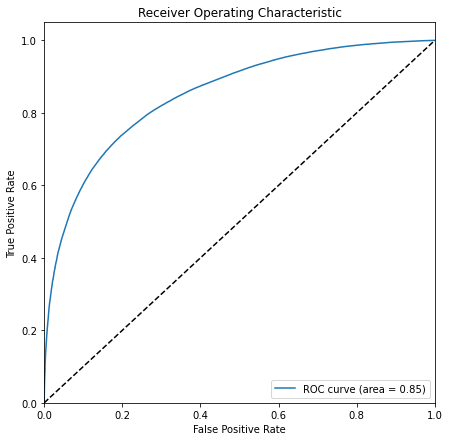

In [217]:
# Generate ROC curve and calculate AUC
probs = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [211]:
# Preprocess the text data
text = " Learning new things is a great way to expand your knowledge and grow as a person."
sequence = tokenizer.texts_to_sequences([text])
X_new = pad_sequences(sequence, maxlen=100)

# Predict the class
y_pred = model.predict(X_new)

# Print the predicted class
if y_pred > 0.5:
    print("The sentence is sarcastic.")
else:
    print("The sentence is not sarcastic.")

The sentence is not sarcastic.


In [102]:
model.save('lstm_model.h5')

## BiLSTM

In [81]:
# Extracting comment and label columns as numpy arrays
X = df['comment'].values
y = df['label'].values
# Creating a tokenizer object and fitting it on the comment text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [82]:
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to a fixed length of 100
X = pad_sequences(X, maxlen=100)

In [83]:
# Test Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# Define a sequential model.
bilstm_model = Sequential()
# Add an embedding layer with input dimension of 10000, output dimension of 128 and input length of X.shape[1].
bilstm_model.add(Embedding(10000, 128, input_length=X.shape[1]))
# Add a bidirectional LSTM layer with 64 units.
bilstm_model.add(Bidirectional(LSTM(64)))
# Add a dropout layer with dropout rate of 0.5.
bilstm_model.add(Dropout(0.5))
# Add a dense layer with one unit and sigmoid activation.
bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
bilstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
scores = bilstm_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
25271/25271 [==============================] - 1399s 55ms/step - loss: 0.5617 - accuracy: 0.7060 - val_loss: 0.5809 - val_accuracy: 0.6910
Epoch 2/5
25271/25271 [==============================] - 1394s 55ms/step - loss: 0.5492 - accuracy: 0.7156 - val_loss: 0.5823 - val_accuracy: 0.6911
Epoch 3/5
25271/25271 [==============================] - 1410s 56ms/step - loss: 0.5370 - accuracy: 0.7241 - val_loss: 0.5872 - val_accuracy: 0.6899
Epoch 4/5
25271/25271 [==============================] - 1424s 56ms/step - loss: 0.5242 - accuracy: 0.7329 - val_loss: 0.5932 - val_accuracy: 0.6891
Epoch 5/5
25271/25271 [==============================] - 1385s 55ms/step - loss: 0.5122 - accuracy: 0.7407 - val_loss: 0.6001 - val_accuracy: 0.6872
Accuracy: 68.72%


In [89]:
y_pred = bilstm_model.predict_classes(X_test)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [90]:
calculate_metrics(y_test, y_pred)

Accuracy:
0.6872025958865486
-------------------------------------------------
Confusion matrix:
[[74875 26225]
 [37012 64054]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70    101100
           1       0.71      0.63      0.67    101066

    accuracy                           0.69    202166
   macro avg       0.69      0.69      0.69    202166
weighted avg       0.69      0.69      0.69    202166

-------------------------------------------------


/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


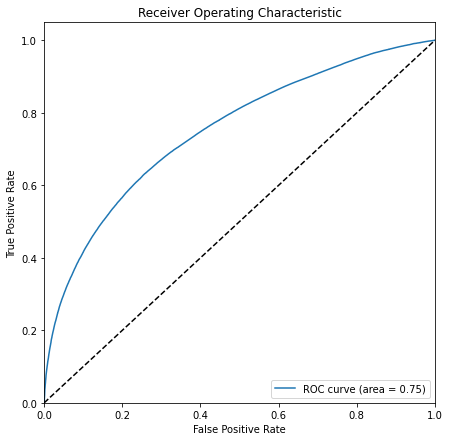

In [91]:
# Generate ROC curve and calculate AUC
probs = bilstm_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [92]:
bilstm_model.save('model_files/bilstm_model.h5')

## Ablation Study

In [117]:
ablated_df = pd.read_csv('data/train-balanced-sarcasm.csv')

In [118]:
# replace NA comments with empty strings
# Identify the columns that have null values
null_mask = ablated_df.isnull()
null_counts = null_mask.sum()

cols_with_nulls = null_counts[null_counts > 0].index.tolist()
ablated_df[cols_with_nulls] = ablated_df[cols_with_nulls].fillna('')

In [119]:
# Stemming data to perform Ablation study for all the models
ablated_df['comment'] = ablated_df['comment'].apply(preprocess_text, stemming=True)

In [120]:
ablated_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west team play west team east team right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdog earlier today sinc gronk announc afte...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme funni none new york nigga one,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tool,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [121]:
# Train Test Split
X = ablated_df['comment']  # Features
y = ablated_df['label']    # Target variable
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

## Ablation Study for NaiveBayes with Smoothing and Stemmed Data

In [68]:
# Create TF-IDF model
tfidf_vectorizer = TfidfVectorizer()
train_features = tfidf_vectorizer.fit_transform(train_data)
test_features = tfidf_vectorizer.transform(test_data)

In [69]:
# Added Alpha smoothing parameter to NaiveBayes model
alpha = 1
ablated_nb_tfidf = MultinomialNB(alpha=alpha)
ablated_nb_tfidf.fit(train_features, train_labels)

MultinomialNB(alpha=1)

In [70]:
test_predictions = ablated_nb_tfidf.predict(test_features)
calculate_metrics(test_labels, test_predictions)

Accuracy:
0.6520433702996548
-------------------------------------------------
Confusion matrix:
[[64426 36674]
 [33671 67395]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    101100
           1       0.65      0.67      0.66    101066

    accuracy                           0.65    202166
   macro avg       0.65      0.65      0.65    202166
weighted avg       0.65      0.65      0.65    202166

-------------------------------------------------


In [101]:
# Save model to a file
file_path = 'ablation_models/nb_tfidf.pkl'

# Open the file for writing
with open(file_path, 'wb') as f:
    # Serialize and write the model to the file
    pickle.dump(ablated_nb_tfidf, f)

## Ablation Study for Logistic Regression with Regularization  and Stemmed Data

In [72]:
# Created Logistic Regression with L2 Regularization
C = 1.0 # regularization parameter
ablated_logistic_regression = LogisticRegression(penalty='l2', C=C)
ablated_logistic_regression.fit(train_features, train_labels)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
# Evaluate performance on test set
test_predictions = ablated_logistic_regression.predict(test_features)
calculate_metrics(test_labels, test_predictions)

Accuracy:
0.6721555553357142
-------------------------------------------------
Confusion matrix:
[[71910 29190]
 [37089 63977]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.71      0.68    101100
           1       0.69      0.63      0.66    101066

    accuracy                           0.67    202166
   macro avg       0.67      0.67      0.67    202166
weighted avg       0.67      0.67      0.67    202166

-------------------------------------------------


In [102]:
# Save model to a file
file_path = 'ablation_models/logistic_regression.pkl'

# Open the file for writing
with open(file_path, 'wb') as f:
    # Serialize and write the model to the file
    pickle.dump(ablated_logistic_regression, f)

## Ablation Study for CNN(modified) with Stemmed Data

In [94]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [95]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Created a new CNN Model with increased size of convolution fitlers
ablation_cnn_model = Sequential()
ablation_cnn_model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
ablation_cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
ablation_cnn_model.add(MaxPooling1D(pool_size=2))
ablation_cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
ablation_cnn_model.add(GlobalMaxPooling1D())
ablation_cnn_model.add(Dense(units=64, activation='relu'))
ablation_cnn_model.add(Dropout(rate=0.2))
ablation_cnn_model.add(Dense(units=1, activation='sigmoid'))
ablation_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
history = ablation_cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
25271/25271 [==============================] - 374s 15ms/step - loss: 0.6072 - accuracy: 0.6630 - val_loss: 0.5842 - val_accuracy: 0.6871
Epoch 2/10
25271/25271 [==============================] - 378s 15ms/step - loss: 0.5658 - accuracy: 0.7052 - val_loss: 0.5816 - val_accuracy: 0.6896
Epoch 3/10
25271/25271 [==============================] - 402s 16ms/step - loss: 0.5429 - accuracy: 0.7225 - val_loss: 0.5876 - val_accuracy: 0.6877
Epoch 4/10
25271/25271 [==============================] - 390s 15ms/step - loss: 0.5199 - accuracy: 0.7407 - val_loss: 0.6018 - val_accuracy: 0.6834
Epoch 5/10
25271/25271 [==============================] - 384s 15ms/step - loss: 0.4941 - accuracy: 0.7583 - val_loss: 0.6105 - val_accuracy: 0.6780
Epoch 6/10
25271/25271 [==============================] - 375s 15ms/step - loss: 0.4647 - accuracy: 0.7765 - val_loss: 0.6372 - val_accuracy: 0.6756
Epoch 7/10
25271/25271 [==============================] - 373s 15ms/step - loss: 0.4351 - accuracy: 0.7943

In [80]:
loss, accuracy = ablation_cnn_model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

6318/6318 [==============================] - 27s 4ms/step - loss: 0.7904 - accuracy: 0.6567
Test loss: 0.7904
Test accuracy: 0.6567


In [79]:
y_pred = ablation_cnn_model.predict_classes(X_test)
calculate_metrics(y_test, y_pred)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy:
0.6567029075116488
-------------------------------------------------
Confusion matrix:
[[67463 33637]
 [35766 65300]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66    101100
           1       0.66      0.65      0.65    101066

    accuracy                           0.66    202166
   macro avg       0.66      0.66      0.66    202166
weighted avg       0.66      0.66      0.66    202166

-------------------------------------------------


In [103]:
ablation_cnn_model.save("ablation_models/cnn_model.h5")

## Ablation Study for BiLSTM(modified) with Stemmed Data

In [96]:
# Created BiLSTM by adding dropout rate to hidden layers
ablated_bilstm_model = Sequential()
ablated_bilstm_model.add(Embedding(10000, 128, input_length=X.shape[1]))
ablated_bilstm_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
ablated_bilstm_model.add(Dropout(0.5))
ablated_bilstm_model.add(Dense(1, activation='sigmoid'))
ablated_bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [98]:
ablated_bilstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
scores = ablated_bilstm_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
25271/25271 [==============================] - 2275s 90ms/step - loss: 0.5935 - accuracy: 0.6788 - val_loss: 0.5800 - val_accuracy: 0.6901
Epoch 2/5
25271/25271 [==============================] - 2289s 91ms/step - loss: 0.5705 - accuracy: 0.6996 - val_loss: 0.5781 - val_accuracy: 0.6919
Epoch 3/5
25271/25271 [==============================] - 2280s 90ms/step - loss: 0.5592 - accuracy: 0.7086 - val_loss: 0.5794 - val_accuracy: 0.6919
Epoch 4/5
25271/25271 [==============================] - 2298s 91ms/step - loss: 0.5501 - accuracy: 0.7157 - val_loss: 0.5817 - val_accuracy: 0.6913
Epoch 5/5
25271/25271 [==============================] - 2294s 91ms/step - loss: 0.5434 - accuracy: 0.7212 - val_loss: 0.5858 - val_accuracy: 0.6905
Accuracy: 69.05%


In [99]:
y_pred = ablated_bilstm_model.predict_classes(X_test)
calculate_metrics(y_test, y_pred)

/Users/sanathkumarvobilisetty/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy:
0.6904672397930414
-------------------------------------------------
Confusion matrix:
[[73785 27315]
 [35262 65804]]
-------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70    101100
           1       0.71      0.65      0.68    101066

    accuracy                           0.69    202166
   macro avg       0.69      0.69      0.69    202166
weighted avg       0.69      0.69      0.69    202166

-------------------------------------------------


In [104]:
ablated_bilstm_model.save("ablation_models/bilstm_model.h5")

## Ablation Study for LSTM(modified) using Stemmed Data

In [132]:
X = ablated_df['comment'].values
y = ablated_df['label'].values
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [133]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

In [136]:
# Created LSTM by adding more LSTM layers and changing Type of Attention mechanism

# Define input layers
input_layer = Input(shape=(100,))

# Define embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)

# Define LSTM layers with attention mechanism
lstm1 = LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)
lstm2 = LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(lstm1)

# Define attention mechanism
attention = Attention()([lstm2, lstm1])

# Define output layer
output_layer = Dense(units=1, activation='sigmoid')(attention)

# Define the model
ablated_lstm_model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
ablated_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [138]:
# Train the model
ablated_lstm_model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)
# Evaluate the model
loss, accuracy = ablated_lstm_model.evaluate(X, y)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/5
25271/25271 [==============================] - 2533s 100ms/step - loss: 0.5900 - accuracy: 0.6811 - val_loss: 0.5772 - val_accuracy: 0.6923
Epoch 2/5
25271/25271 [==============================] - 2430s 96ms/step - loss: 0.5655 - accuracy: 0.7022 - val_loss: 0.5709 - val_accuracy: 0.6987
Epoch 3/5
25271/25271 [==============================] - 2415s 96ms/step - loss: 0.5515 - accuracy: 0.7133 - val_loss: 0.5760 - val_accuracy: 0.6952
Epoch 4/5
25271/25271 [==============================] - 2393s 95ms/step - loss: 0.5403 - accuracy: 0.7219 - val_loss: 0.5802 - val_accuracy: 0.6933
Epoch 5/5
31589/31589 [==============================] - 511s 16ms/step - loss: 0.5178 - accuracy: 0.7405
Loss:  0.5178472995758057
Accuracy:  0.7404630184173584


In [150]:
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  0.5178472995758057
Accuracy:  0.7404630184173584


In [151]:
ablated_lstm_model.save("ablation_models/lstm_model.h5")